# Library import

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torch.utils.data as data
from torchvision import datasets, transforms, utils
import torch
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wandb

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

import warnings
warnings.filterwarnings('ignore')

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device = {device}")

device = cpu


# Hyperparameters

In [7]:
model_name = "first_architecture"
eval_every = 5
save_every = 10

# est-ce qu'on pourrait pas faire des batch size différent pour le train et le test/validation ?
# as-tu d'autres idée d'hyperparametre ?
batch_size = 32
learning_rate = 0.001
nb_epochs = 10


# if ask for a key, COPY/PASTE bc0dc5f66039bf86ffba73188a299faed907973c
wandb.init(
    project="deep_learning_project", 
    config = {
        "model": model_name,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "nb_epochs": nb_epochs,
        "eval_every": eval_every,
        "save_every": save_every,
    },
    name=model_name,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jimmy-walraff02 (data-science-project). Use `wandb login --relogin` to force relogin


In [9]:
# wandb.finish()

# Dataset import

In [9]:
print(os.getcwd())
os.chdir("/scratch/users/jwalraff/DeepWalraff/augmented_dataset")
print(os.getcwd())
print(os.listdir(os.getcwd()))

/scratch/users/jwalraff/DeepWalraff
/scratch/users/jwalraff/DeepWalraff/augmented_dataset
['test', 'train', 'validation']


In [7]:
import datasetCreation

root_dir = "/scratch/users/jwalraff/DeepWalraff/augmented_dataset"
validation_dir = os.path.join(root_dir, "validation")
categories = os.listdir(validation_dir)

transform = transforms.Compose([
    transforms.ToTensor()
])

train_loader = datasetCreation.getDataLoader(root_dir, 32, num_workers= 4, mode='train', transform=transform)
validation_loader = datasetCreation.getDataLoader(root_dir, 32, mode='validation', transform=transform)
test_loader = datasetCreation.getDataLoader(root_dir, 32, mode='test', transform=transform)

<class 'torch.Tensor'>


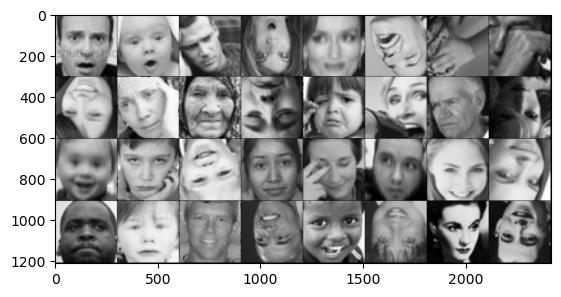

surprised surprised sad surprised happy happy sad sad happy fearful neutral sad sad happy sad neutral happy neutral happy sad neutral fearful happy happy angry sad happy happy happy happy neutral happy


In [8]:
# comes from hw2
def show_images(img):
    plt.imshow(transforms.functional.to_pil_image(img), cmap='gray')
    plt.show()

# show the images from a batch
images, labels = next(iter(train_loader))
print(type(images))
show_images(utils.make_grid(images))
print(*[categories[l] for l in labels])

# Class Weights

In [4]:
# source of the formula https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
weights = []
n_sample = sum(train_counts)
n_category = len(categories)

for i, n_sample_i in enumerate(train_counts):
    weights.append(n_sample/(n_category*n_sample_i))

weights = torch.tensor(weights, dtype=torch.float)
weights

NameError: name 'train_counts' is not defined

# Model

In [12]:
class ConvNet(nn.Module):
    def __init__(self):
        # basic architecture from slide 35/59 lecture 6 of deep learning course
        # INPUT → [[CONV → ReLU]*N → POOL?]*M → [FC → ReLU]*K → FC
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64*73*73, 128) # aucune idée de si c'est juste (merci copilot, apres avec un run, je saurais change ceci) (pour le 64*73*73)
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64*73*73) # pareil ici (pour le 64*73*73)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
convnet = ConvNet()
convnet.train()

print(f"convnet architecture: \n{convnet}")

# from https://saturncloud.io/blog/check-the-total-number-of-parameters-in-a-pytorch-model/#:~:text=To%20check%20the%20number%20of%20parameters%20in%20a%20PyTorch%20model,its%20total%20number%20of%20elements
print(f"\n numbers of parameters: {sum(p.numel() for p in convnet.parameters())}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(convnet.parameters(), lr=learning_rate)

convnet architecture: 
ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=341056, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)

 numbers of parameters: 43675015


# Training

Faut-il rajouter plus de truc dans wandb.log ?

In [16]:
def train_cnn(num_epochs):
    train_avg_loss = []
    validation_avg_loss = []
    validation_accuracy = []

    # transfer cnn to GPU (in-place)
    convnet.to(device)

    print("Entering epoch loops.....")
    for i in range(num_epochs):
        train_losses = []
        validation_losses = []
        recall_scores = []
        precision_scores = []
        f1_scores = []

        print("Entering train loop....")
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            pred = convnet(x)
            loss = criterion(pred, y)

            wandb.log({
                "epoch": i, 
                "train_loss": loss
            })

            train_losses.append(loss.detach())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_avg_loss.append(np.array(train_losses).mean())

        # à modifier en fonction du nb d'epoch qu'on met
        if i % eval_every == 0:
            print("Entering validation.....")
            with torch.no_grad():
                correct = 0

                # list because we wan't evaluate on each batch (some labels might not be in a batch)
                true_labels = torch.tensor([])
                pred_labels = torch.tensor([])

                for x, y in validation_loader:
                    x = x.to(device)
                    y = y.to(device)

                    pred = convnet(x)
                    loss = criterion(pred, y)

                    wandb.log({
                        "epoch": i, 
                        "validation_loss": loss
                    })

                    validation_losses.append(loss.detach())

                    y_pred = pred.argmax(dim=-1)
                    correct = correct + (y_pred == y).sum()

                    true_labels = torch.cat((true_labels, y.cpu()))
                    pred_labels = torch.cat((pred_labels, y_pred.cpu()))

                recall_scores.append(recall_score(true_labels, pred_labels))
                precision_scores.append(precision_score(true_labels, pred_labels))
                f1_scores.append(f1_score(true_labels, pred_labels))

                validation_avg_loss.append(np.array(validation_losses).mean())
                accuracy = correct / len(validation_set)
                validation_accuracy.append(accuracy)

                print(f"Epoch {i}")
                print("************************************")
                print()

            if i % save_every == 0:
                torch.save(convnet.state_dict(), f"model_intermediate/convnet_{i}.pt")

    train_avg_loss = np.array(train_avg_loss)
    validation_avg_loss = np.array(validation_avg_loss)

    torch.save(convnet.state_dict(), f"model_finished/convnet__finished_{num_epochs}.pt")

    return train_avg_loss, validation_avg_loss, validation_accuracy, recall_scores, precision_scores, f1_scores

In [17]:
train_avg_loss, validation_avg_loss, validation_accuracy, recall_scores, precision_scores, f1_scores = train_cnn(nb_epochs)

Entering epoch loops.....
Entering train loop....


KeyboardInterrupt: 